In [2]:
import torch
import torchvision
import numpy as np

In [3]:
n_epochs = 3
batch_size_train = 10
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [4]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz to /files/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz to /files/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz to /files/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz to /files/MNIST/raw



In [14]:
# Additional Training Input & Output Data
def create_additional_input_data():
  input_data_additional = []
  for batch_idx, (data, target) in enumerate(train_loader):
    batch_size_input = len(data)
    A = np.random.randint(low=0, high=9, size=(batch_size_input,))
    input_data_additional.append(A)

  new_array = np.array(input_data_additional).flatten()
  return new_array

train_input_2 = create_additional_input_data()
len(train_input_2)

output_data_additional = []
for batch_idx, (data, target) in enumerate(train_loader):
  temp = target.cpu().detach().numpy()
  output_data_additional.append(temp)

train_output_1 = np.array(output_data_additional).flatten()
train_output_2 = train_input_2+train_output_1


In [15]:
# Additional Training Input & Output Data
def create_additional_input_data_test():
  input_data_additional = []
  for batch_idx, (data, target) in enumerate(test_loader):
    batch_size_input = len(data)
    A = np.random.randint(low=0, high=9, size=(batch_size_input,))
    input_data_additional.append(A)

  new_array = np.array(input_data_additional).flatten()
  return new_array

test_input_2 = create_additional_input_data_test()
len(test_input_2)

output_data_additional = []
for batch_idx, (data, target) in enumerate(test_loader):
  temp = target.cpu().detach().numpy()
  output_data_additional.append(temp)

test_output_1 = np.array(output_data_additional).flatten()
test_output_2 = test_input_2+test_output_1


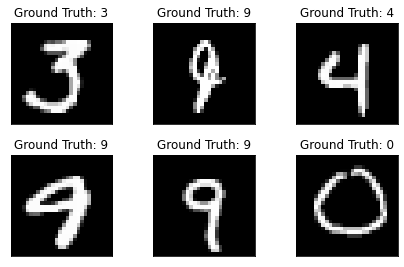

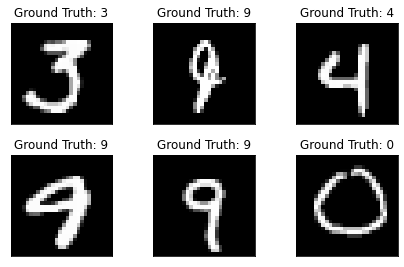

In [11]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [12]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [75]:
# https://stackoverflow.com/questions/51700729/how-to-construct-a-network-with-two-inputs-in-pytorch

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5) # self.conv1 = nn.Conv2d(1, 10, kernel_size=3) is a line of code in PyTorch that creates a 2D convolutional layer with 1 input channel, 10 output channels, and a 5x5 kernel size.
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5) # self.conv2 = nn.Conv2d(10, 20, kernel_size=3) is a line of code in PyTorch that creates a 2D convolutional layer with 10 input channels, 20 output channels, and a 5x5 kernel size.
        self.conv2_drop = nn.Dropout2d() # self.conv2_drop = nn.Dropout2d() is a line of code in PyTorch that creates a 2D dropout layer.
        self.fc1 = nn.Linear(320, 50) #  self.fc1 = nn.Linear(320, 50) is a line of code in PyTorch that creates a fully connected layer with 320 input units and 50 output units.
        self.fc2 = nn.Linear(50, 10)
        self.fc3 = nn.Linear(10, 320)

    def forward(self, x, x2):
        x = F.relu(F.max_pool2d(self.conv1(x), 2)) # x = F.relu(F.max_pool2d(self.conv1(x), 2)) is a line of code in PyTorch that applies a 2x2 max pooling layer with ReLU activation to the output of a convolutional layer.
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2)) # x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2)) is a line of code in PyTorch that applies a 2x2 max pooling layer with ReLU activation to the output of a convolutional layer with dropout applied.
        x = x.view(-1, 320) # x = x.view(-1, 320) is a line of code in PyTorch that reshapes a tensor into a 2D matrix with 320 columns.
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training) # Dropout is a regularization technique used in machine learning to reduce overfitting by randomly setting some of the input units to 0 during the forward pass.
        x = self.fc2(x)
        f = F.relu(self.fc3(x2))
        f = F.dropout(f, training=self.training)
        f = F.relu(self.fc1(f))
        f = F.dropout(f, training=self.training) 
        f = F.relu(self.fc2(f))

        return F.log_softmax(x) , f

In [76]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [77]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [94]:
# MNIST Data
# This is a block to understand the inner workings of the neural network

test = F.relu(F.max_pool2d(nn.Conv2d(1, 10, kernel_size=5)(data[1]),2))
test2 = F.relu(F.max_pool2d(nn.Conv2d(10, 20, kernel_size=5)(test),2))
test3 = test2.view(-1, 320)
test4 = F.relu(nn.Linear(320, 50)(test3))
test5 = F.dropout(test4, training=True)
test6 = F.relu(nn.Linear(50, 10)(test5))
test7 = F.log_softmax(test6)
print(test.shape)
print(test2.shape)
print(test3.shape)
print(test4.shape)
print(test5.shape)
print(test6.shape)
print(test6)
print(test7)

# Additional Input
A = torch.randint(0, 10, (batch_size_train,))
A = torch.tensor(A, dtype=torch.float32)
print(A)
temp = F.relu(nn.Linear(10, 320)(A))
temp2 = F.dropout(temp, training=True)
temp3 = F.relu(nn.Linear(320, 50)(temp2))
temp4 = F.dropout(temp3, training=True)
temp5 = F.relu(nn.Linear(50, 10)(temp4))
temp6 = F.log_softmax(temp5)
print(temp.shape)
print(temp2.shape)
print(temp3.shape)
print(temp4.shape)
print(temp5.shape)
print(temp5)
print(temp6)

torch.Size([10, 12, 12])
torch.Size([20, 4, 4])
torch.Size([1, 320])
torch.Size([1, 50])
torch.Size([1, 50])
torch.Size([1, 10])
tensor([[0.0000, 0.0000, 0.0000, 0.0612, 0.1467, 0.0000, 0.1707, 0.0000, 0.2081,
         0.0000]], grad_fn=<ReluBackward0>)
tensor([[-2.3645, -2.3645, -2.3645, -2.3033, -2.2178, -2.3645, -2.1938, -2.3645,
         -2.1564, -2.3645]], grad_fn=<LogSoftmaxBackward0>)
tensor([8., 6., 8., 2., 9., 3., 9., 3., 3., 8.])
torch.Size([320])
torch.Size([320])
torch.Size([50])
torch.Size([50])
torch.Size([10])
tensor([0.0000, 0.0000, 0.0000, 2.1233, 0.0048, 0.0000, 0.0000, 0.0000, 0.4035,
        0.3781], grad_fn=<ReluBackward0>)
tensor([-2.9080, -2.9080, -2.9080, -0.7847, -2.9032, -2.9080, -2.9080, -2.9080,
        -2.5045, -2.5299], grad_fn=<LogSoftmaxBackward0>)


<ipython-input-94-e1b99bd075f3>:9: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  test7 = F.log_softmax(test6)
<ipython-input-94-e1b99bd075f3>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A = torch.tensor(A, dtype=torch.float32)
<ipython-input-94-e1b99bd075f3>:28: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  temp6 = F.log_softmax(temp5)


In [98]:
network.train()
optimizer.zero_grad()
data, target = next(iter(train_loader))
A = torch.randint(0, 10, (batch_size_train,))
A = torch.tensor(A, dtype=torch.float32)
output = network(data, A)
network1_output = torch.tensor(output[0], dtype=torch.float32)
loss = F.cross_entropy(network1_output, target)
loss.item()

<ipython-input-98-89353ba47383>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A = torch.tensor(A, dtype=torch.float32)
<ipython-input-75-c1e0b23f45d7>:26: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x) , F.log_softmax(f)
<ipython-input-98-89353ba47383>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  network1_output = torch.tensor(output[0], dtype=torch.float32)


2.2471871376037598

In [40]:
A = torch.randint(0, 10, (batch_size_train,))
A = torch.tensor(A, dtype=torch.float32)
m = nn.Linear(10, 320)
y = m(A)
f = F.dropout(y, training=True)
print(type(f))
print(f.shape)
m2 = nn.Linear(320,50)
f2 = m2(f)
print(f2.shape)
f2 = F.dropout(f2, training=True) 
print(f2.shape)
m3 = nn.Linear(50, 10)
f3 = m3(f2)
print(f3.shape)

<class 'torch.Tensor'>
torch.Size([320])
torch.Size([50])
torch.Size([50])
torch.Size([10])


<ipython-input-40-14ff0865a967>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A = torch.tensor(A, dtype=torch.float32)


In [ ]:
new_data_loader = torch.utils.data.DataLoader([train_loader, ])

In [11]:
def train(epoch):
  network.train() # network.train() sets the model in training mode, which enables features such as dropout and batch normalization.
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), '/content/model.pth')
      torch.save(optimizer.state_dict(), '/content/optimizer.pth')

In [12]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [ ]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()
  print(epoch)

In [14]:
test_losses

[2.3095823486328126,
 0.18577103729248046,
 0.11585923309326172,
 0.09897374267578125]

In [15]:
test_counter

[0, 60000, 120000, 180000]

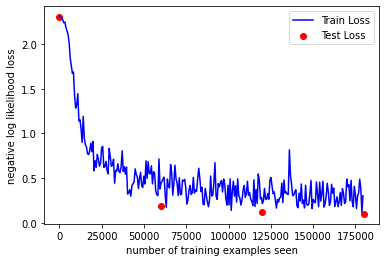

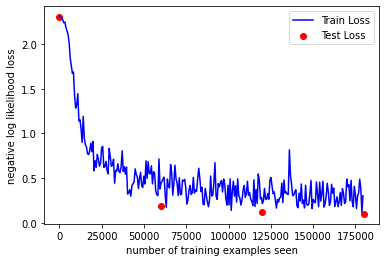

In [16]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig

In [17]:
with torch.no_grad():
  output = network(example_data)

<ipython-input-8-6c2218f37724>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


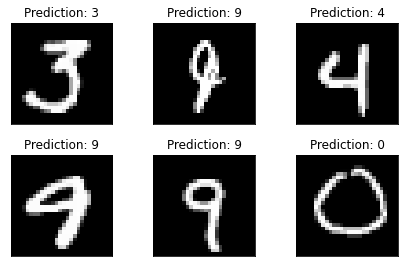

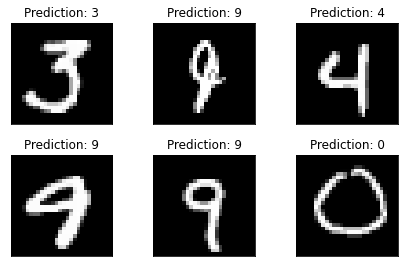

In [18]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig

In [19]:
continued_network = Net()
continued_optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                                momentum=momentum)

In [26]:
x = torch.tensor([4, 3, 2, 1, 0, 9])
F.one_hot(x, num_classes=10)

tensor([[0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])

In [31]:
y = torch.tensor([5, 3, 0, 1, 2, 7])
print(x)
print(y)
z = x + y
one_hot = F.one_hot(z, num_classes=20)

tensor([4, 3, 2, 1, 0, 9])
tensor([5, 3, 0, 1, 2, 7])


In [32]:
torch.argmax(one_hot, dim=1)

tensor([ 9,  6,  2,  2,  2, 16])

In [43]:
labels = torch.randint(0, 10, (20,)) # this function generates values between 0 to 10 and the 2nd number in brackets, specifies the number of valus to be generated

# labels --> one-hot 
one_hot = torch.nn.functional.one_hot(labels)
print(one_hot)
# one-hot --> labels
labels_again = torch.argmax(one_hot, dim=1)
print(labels_again)

tensor([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]])
tensor([5, 6, 7, 5, 3, 0, 4, 3, 4, 9, 5, 1, 4, 9, 5, 5, 6, 4, 7, 2])


In [61]:
def convert_to_one_hot_encoding(input_data, num_classes):
  one_hot = torch.nn.functional.one_hot(input_data, num_classes = num_classes)
  return one_hot

def convert_to_labels(input_data):
  output = torch.argmax(input_data, dim=1)
  return output

In [64]:
labels = torch.randint(0, 10, (10,))
input1 = convert_to_one_hot_encoding(labels, 10)
input2 = convert_to_labels(input1)
print(input1)
print(input2)


tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]])
tensor([0, 0, 7, 5, 3, 5, 5, 9, 9, 2])


In [ ]:
def train(epoch):
  network.train() # network.train() sets the model in training mode, which enables features such as dropout and batch normalization.
  for batch_idx, (data, target) in enumerate(train_loader): # 
    optimizer.zero_grad() 
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), '/content/model.pth')
      torch.save(optimizer.state_dict(), '/content/optimizer.pth')

In [72]:
num_classes_needed = 10
network.train()
for batch_idx, (data, target) in enumerate(train_loader):
  size = len(data)
  labels = torch.randint(0, 10, (size,))
  one_hot_encoded_labels = convert_to_one_hot_encoding(labels, num_classes_needed)
  back_to_labels = convert_to_labels(one_hot_encoded_labels)
  if batch_idx == 1:  
    print(size)
    print(len(labels))
    print(labels)
    print(one_hot_encoded_labels)
    print(back_to_labels)
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    print(type(data))
    print(data.shape)
    print(data.ndim)
    print(data[1])
    print(type(output))
    print(output.shape)
    print(output.ndim)
    print(loss)
    break


10
10
tensor([6, 3, 0, 3, 1, 7, 9, 6, 0, 5])
tensor([[0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]])
tensor([6, 3, 0, 3, 1, 7, 9, 6, 0, 5])
<class 'torch.Tensor'>
torch.Size([10, 1, 28, 28])
4
tensor([[[-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4

<ipython-input-8-6c2218f37724>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [20]:
network_state_dict = torch.load('/content/model.pth')
continued_network.load_state_dict(network_state_dict)

optimizer_state_dict = torch.load('/content/model.pth')
continued_optimizer.load_state_dict(optimizer_state_dict)

KeyError: ignored

In [ ]:
for i in range(4,9):
  test_counter.append(i*len(train_loader.dataset))
  train(i)
  test()

In [ ]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig

ModuleNotFoundError: ignored